# Check models
Script checking the performance of nine CNN models on data the was not used to create the model

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, cohen_kappa_score, precision_score, recall_score

## GPU is not necessary!
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [2]:
##
# Folds reconstruction (the same as in build_cnn_models.ipynb script)

non_parts = [ 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,15,16,18,19,20,21,22]
dys_parts = [23,24,25,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41]

folds = []
for i in range(0,18,2):
    folds.append([non_parts[i],dys_parts[i],non_parts[i+1],dys_parts[i+1]])

print(folds)

[[2, 23, 3, 24], [4, 25, 5, 26], [6, 27, 7, 28], [8, 29, 9, 30], [10, 31, 11, 33], [12, 34, 15, 35], [16, 36, 18, 37], [19, 38, 20, 39], [21, 40, 22, 41]]


In [6]:
##
# Load images - label is now equal to subject id
import cv2
import os
def load_img(indir):
    samples = []
    labels = []
    for file in os.listdir(indir):
        #print(file)
        if not file.endswith('jpg'):
            continue
        image = cv2.imread("{}/{}".format(indir,file))
            #print(image.shape)
        image = image[:150,:150,:]
        samples.append(image)
        the_class = int(file[1:3])
        labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('gssp_old')
print('loaded',len(samples),' samples')

print('classes',set(labels))


loaded 3321  samples
classes {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58}



== FOLD: 0  of  [2, 23, 3, 24] ==
2/2 [==============================] - 0s 42ms/step
Subject: 2 class: 0 test samples: 43 mean score: 0.31060877
2/2 [==============================] - 0s 8ms/step
Subject: 23 class: 1 test samples: 33 mean score: 0.5961838
3/3 [==============================] - 0s 84ms/step
Subject: 3 class: 0 test samples: 80 mean score: 0.5260822
1/1 [==============================] - 0s 118ms/step
Subject: 24 class: 1 test samples: 27 mean score: 0.72642493

== FOLD: 1  of  [4, 25, 5, 26] ==
1/1 [==============================] - 0s 275ms/step
Subject: 4 class: 0 test samples: 32 mean score: 0.71962297
2/2 [==============================] - 0s 89ms/step
Subject: 25 class: 1 test samples: 57 mean score: 0.8745983
3/3 [==============================] - 0s 83ms/step
Subject: 5 class: 0 test samples: 75 mean score: 0.4144078
2/2 [==============================] - 0s 54ms/step
Subject: 26 class: 1 test samples: 47 mean score: 0.94475216

== FOLD: 2  of  [6, 27, 7, 28] =

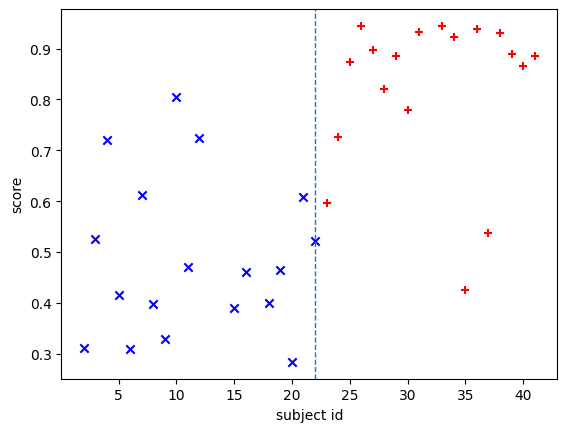

AUC value: 0.9320987654320987
[[17  1]
 [ 3 15]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.94      0.83      0.88        18

    accuracy                           0.89        36
   macro avg       0.89      0.89      0.89        36
weighted avg       0.89      0.89      0.89        36

Cohen's Kappa: 0.7777777777777778
F1-score 0.8823529411764706
Accuracy:  0.8888888888888888


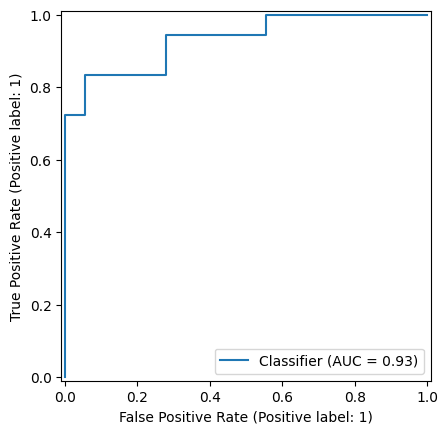

In [16]:
##
# Calculate scores for each fold using the correct model

aucs = []
y_trues = []
y_scores = []
y_medians = []
y_results = []

all_scores = []
all_trues = []
all_labels = []
means = {}

for i,f in enumerate(folds):
    print()
    print("== FOLD:",i," of ",f,"==")
    y_true = []
    y_score = []
    y_result = []
    model =  tf.keras.models.load_model(f'final_f{i}_model.h5',compile=False)
    for j in f:
        # choose only samples not used for model's training!
        testSamples = samples[np.where(labels==j)]
        #print(f"{j}: {testSamples.shape}")
        if j<=22:
            the_class = 0
        else:
            the_class = 1
        testResults = model.predict(testSamples)
        mean_value = np.mean(testResults) #/np.max(testResults[np.where(testLabels==i)])
        print("Subject:",j, "class:",the_class, "test samples:",testSamples.shape[0], "mean score:", mean_value, )
        y_trues.append(the_class)
        y_scores.append(mean_value)
        x = len(testResults)
        # add results to the set of all results
        all_trues.extend(list([the_class]* x)) # true classifications
        all_scores.extend(testResults) # scores obtained from the model
        all_labels.extend(list([j]* x)) # subject id
        means[j]=mean_value  

for p in means:
    if p<=22:
        color = 'blue'
        marker = 'x'
    else:
        color = 'red'
        marker = '+'
    plt.scatter(p, means[p], label=f"{p}",color=color, marker=marker)
plt.axvline(x = 22, linewidth=1, ls='dashed', label = f'')
plt.xlabel("subject id")
plt.ylabel("score")
plt.show()

print("AUC value:",sklearn.metrics.roc_auc_score(y_trues, y_scores))

t=0.725
y_results = []
for s in y_scores:
    if s>t:
        y_results.append(1)
    else:
        y_results.append(0)


print(confusion_matrix(y_trues,y_results))
print(classification_report(y_trues,y_results))
print("Cohen's Kappa: {}".format(cohen_kappa_score(y_trues,y_results)))
print("F1-score",sklearn.metrics.f1_score(y_trues,y_results))
print("Accuracy: ",accuracy_score(y_trues,y_results))
RocCurveDisplay.from_predictions(y_trues, y_scores)
#print(sum(aucs)/10)

Max accuracy: 0.8888888888888888  for threshold:  0.724


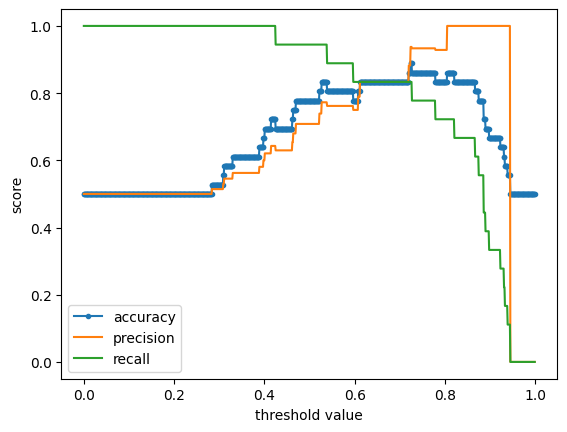

In [55]:
acc = {}
prec = {}
recall = {}
for t100 in range(1000): 
    t = t100/1000
    y_results = []
    for s in y_scores:
        if s>t:
            y_results.append(1)
        else:
            y_results.append(0)

#    print("Treshold:",t, "Accuracy: ",accuracy_score(y_trues,y_results))
    acc[t] = accuracy_score(y_trues,y_results)
    prec[t] = precision_score(y_trues,y_results,zero_division=0)
    recall[t] = recall_score(y_trues,y_results,zero_division=0)

plt.plot(acc.keys(),acc.values(),label='accuracy',marker='.')
plt.plot(prec.keys(),prec.values(),label='precision')
plt.plot(recall.keys(),recall.values(),label='recall')
plt.legend(loc="lower left")
plt.xlabel("threshold value")
plt.ylabel("score")

print("Max accuracy:",max(acc.values()), " for threshold: ",
      list(acc.keys())[list(acc.values()).index(max(acc.values()))])

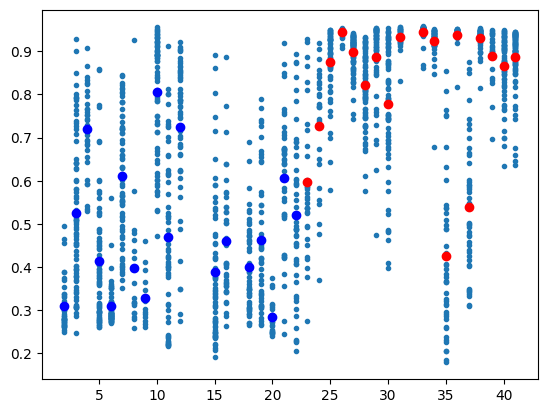

In [60]:
##
# Analysis for all GSSPs separately (not averaged per subject)

plt.scatter(all_labels,all_scores,marker='.')
for p in means:
    if p<=22:
        color = 'blue'
    else:
        color = 'red'
    plt.scatter(p, means[p], label=f"{p}",color=color)
plt.show()

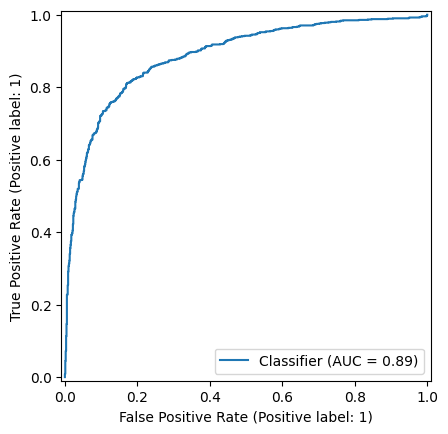

In [59]:
#print("AUC value:",sklearn.metrics.roc_auc_score(all_trues, all_scores))
RocCurveDisplay.from_predictions(all_trues, all_scores)

Max accuracy: 0.8197802197802198  for threshold:  0.74


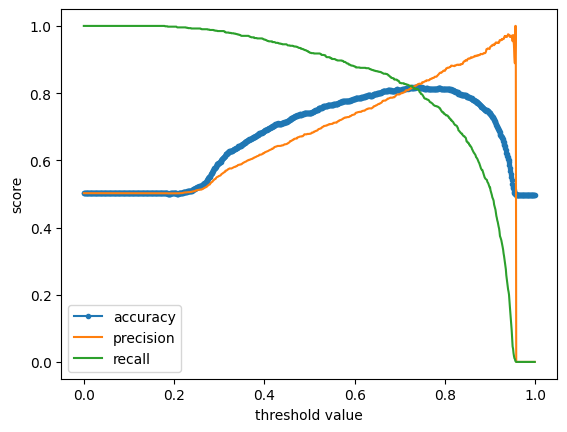

In [57]:
acc = {}
prec = {}
recall = {}
for t100 in range(1000): 
    t = t100/1000
    all_results = []
    for s in all_scores:
        if s>t:
            all_results.append(1)
        else:
            all_results.append(0)

#    print(Threshold:",t, "Accuracy: ",accuracy_score(all_trues,all_results))
    acc[t] = accuracy_score(all_trues,all_results)
    prec[t] = precision_score(all_trues,all_results,zero_division=0)
    recall[t] = recall_score(all_trues,all_results,zero_division=0)

plt.plot(acc.keys(),acc.values(),label='accuracy',marker='.')
plt.plot(prec.keys(),prec.values(),label='precision')
plt.plot(recall.keys(),recall.values(),label='recall')
plt.legend(loc="lower left")
plt.xlabel("threshold value")
plt.ylabel("score")


print("Max accuracy:",max(acc.values()), " for threshold: ",
      list(acc.keys())[list(acc.values()).index(max(acc.values()))])